<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/FloodPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e5:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73278%2F8121328%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T002130Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c7fb49fa80c551e523c45272200967b89c4ae8fc6deaf7daef77d310a10dc4d4fcd1f1c526440f69892c4efbfc72c4639eff55ae05c9751727d2dd046dee409d39712a98ce3a51145dee7dbefe5fbfea70dd17c7d0c468b20188ea19d191a9e4265513a7d57265422ffe29f95a9da47b5a8200d88fc4f863e1418ed476d1ff8baf126dc02683e7eb59ccc36895d4c69c8386d3186118ded51be41df69494d0dc12ca7d95b5e35e058f74d4717a5ec2bc6994a3f36bd201390e5ba9df8e1a78f43d75eb66976ecfa55d38f35250ab1b635abba32953fc93089edf9da67bca382ec34c2a1c8a28d918102d866940fc9f4a1238d4b191f0c28bef13eb04b8eab2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


## **Imports**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor

## **Data loading**

In [ ]:
base_folder_path = "/kaggle/input/playground-series-s4e5"
train_data = pd.read_csv(os.path.join(base_folder_path, "train.csv"))
test_data = pd.read_csv(os.path.join(base_folder_path, "test.csv"))

## **Data Exploration**

In [ ]:
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [ ]:
# No null counts?
print(f"No nulls, right? \n> {all(train_data.isnull().sum() == 0)}")

No nulls, right? 
> True


In [ ]:
# Data type information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

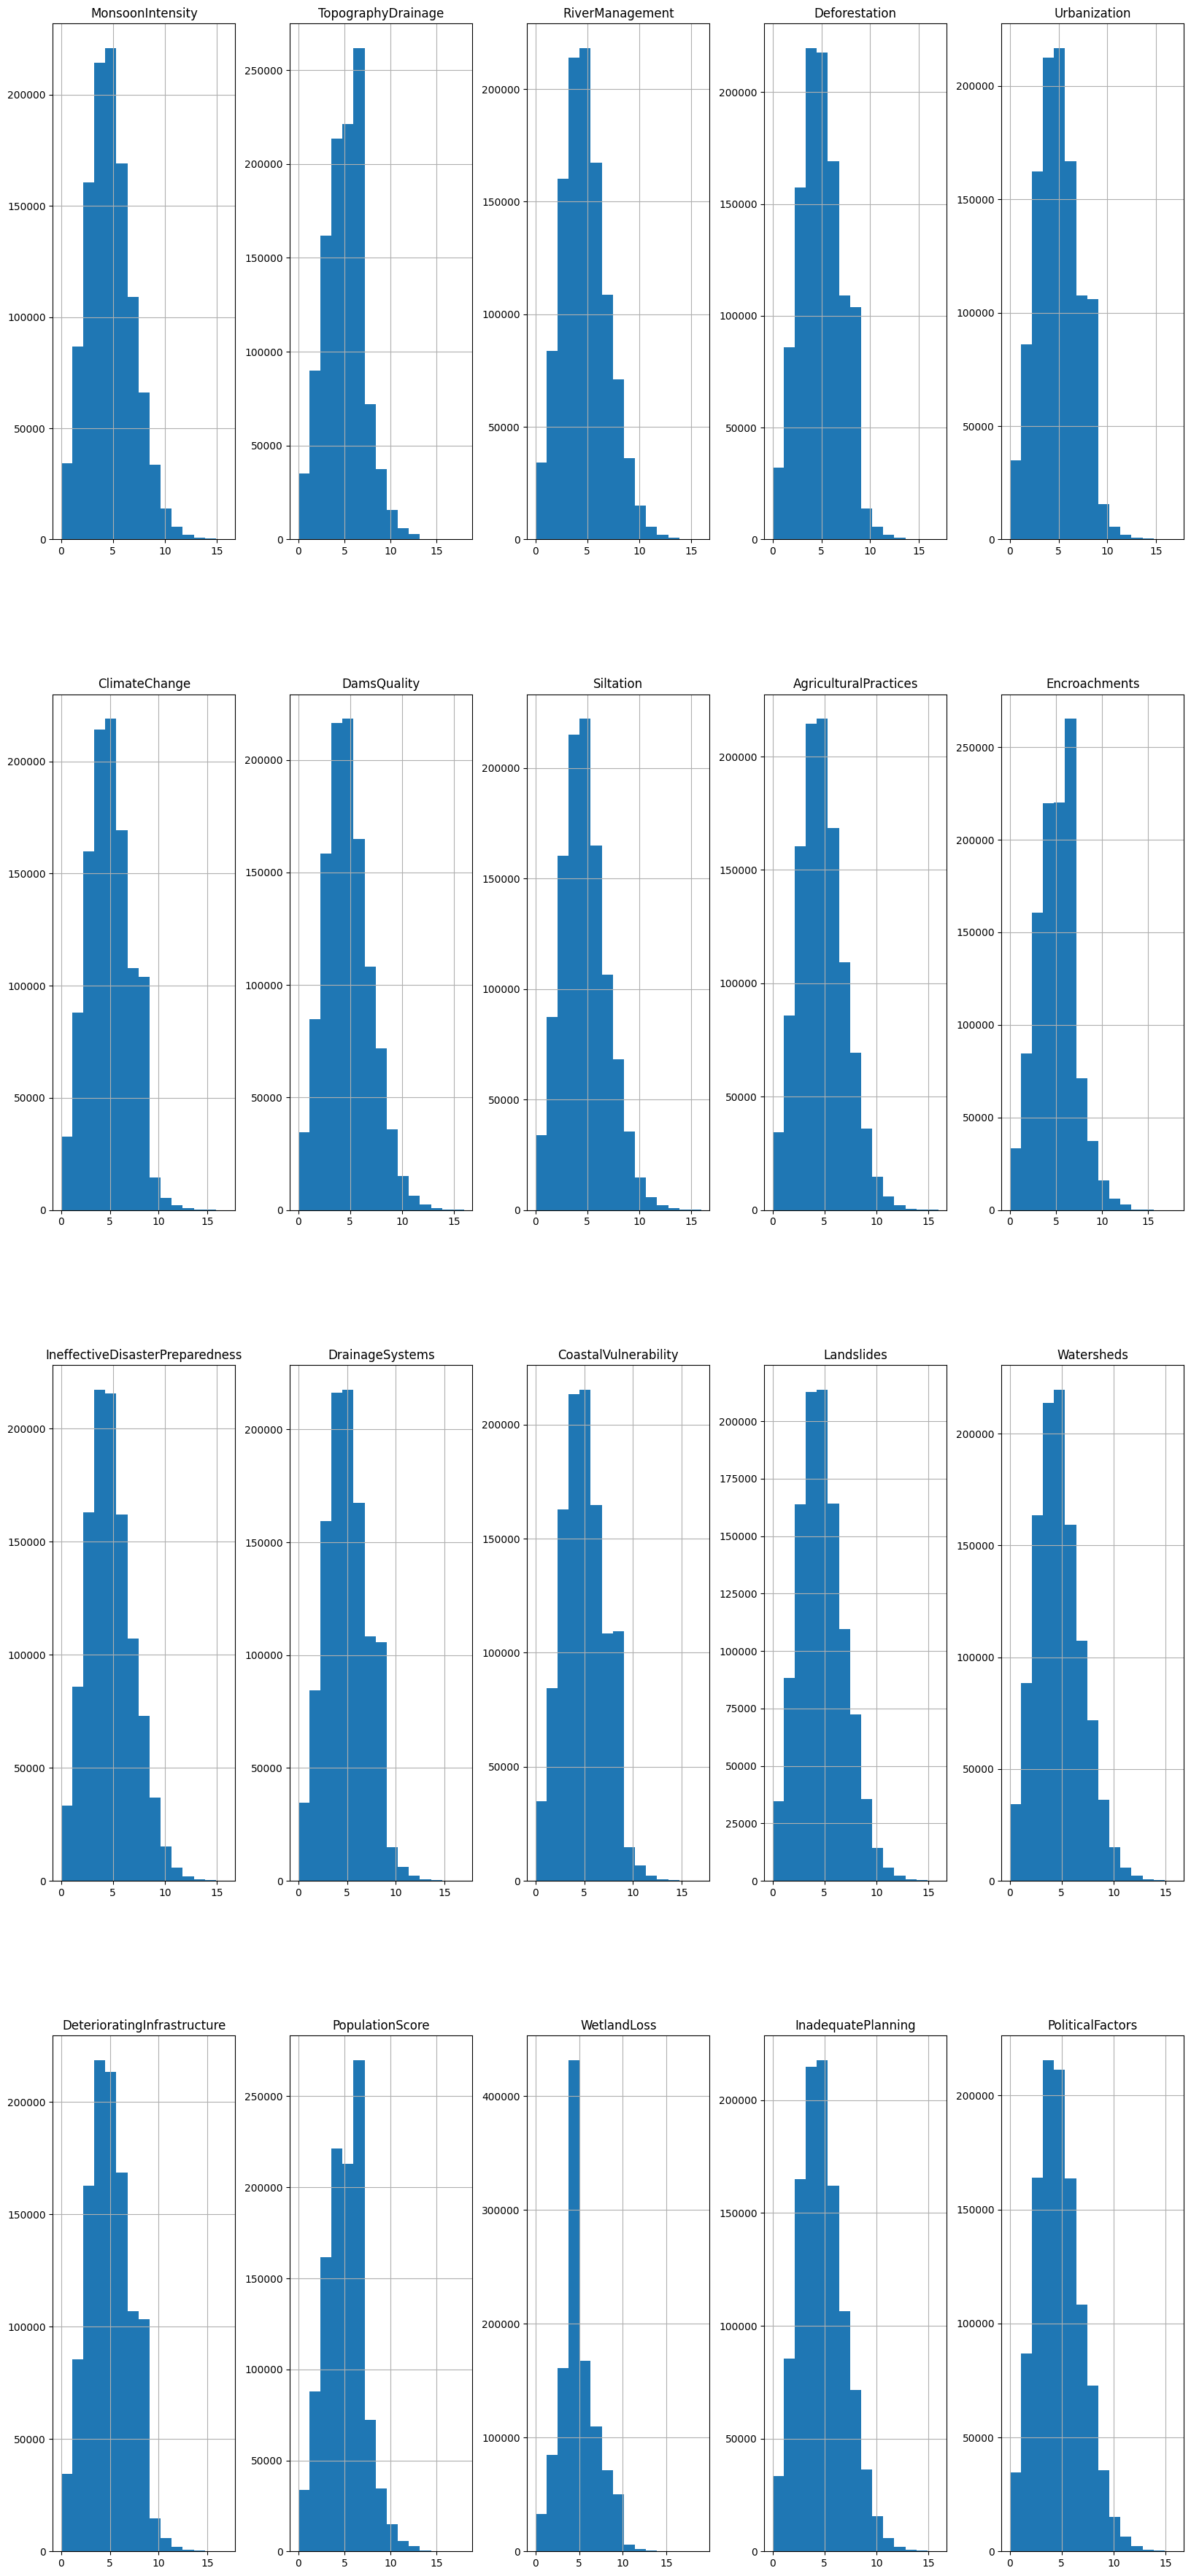

In [ ]:
# Layout of data
features_train = train_data.set_index("id")
target_column = "FloodProbability"
label_train = features_train.pop(target_column)
features_train.hist(bins=15, figsize=(20, 45), layout=(4, 5))

> Looks like well distributed data

### Visualizing standardized training data

Standardizing data just for sanity

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

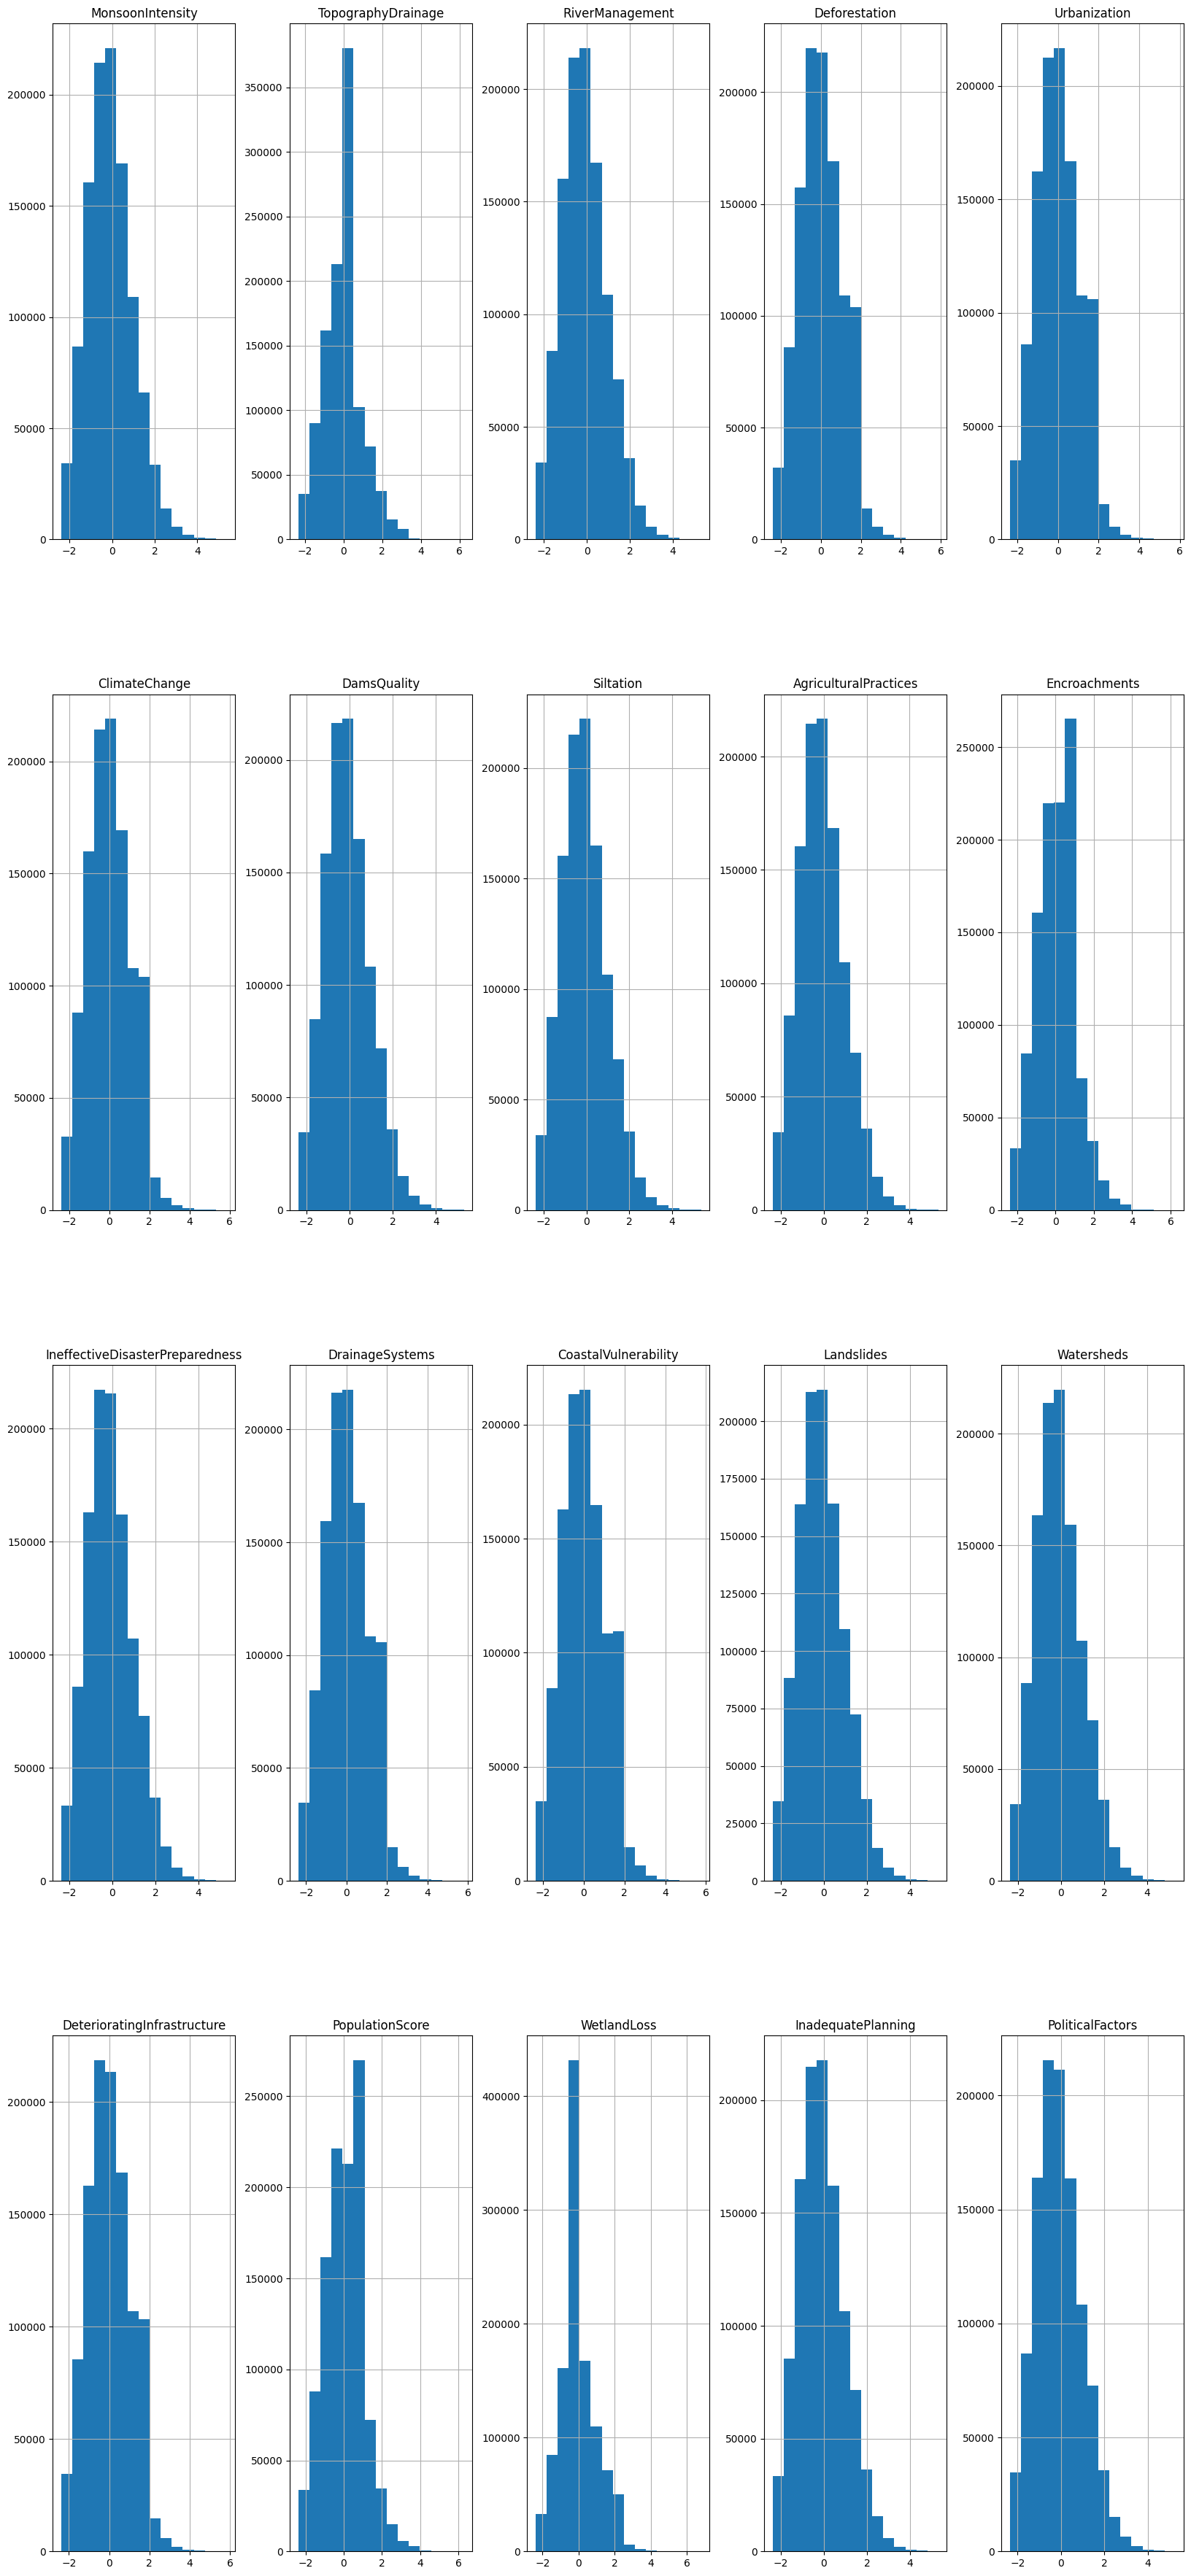

In [ ]:
def standardize(data):
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    return standard_scaler.transform(data)

features_train_standardized = pd.DataFrame(standardize(features_train), columns=features_train.columns)
features_train_standardized.hist(bins=15, figsize=(20, 45), layout=(4, 5))

> The data was already pretty standardized too.

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

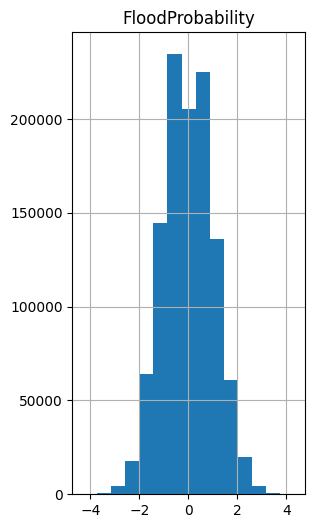

In [ ]:
# Repeating for the target
def standardize_labels(label_data):
    mean, std = label_data.mean(), label_data.std()
    return label_data.apply(lambda v: (v - mean) / std)


label_train_standardized = pd.DataFrame(standardize_labels(label_train), columns=[target_column])
label_train_standardized.hist(bins=15, figsize=(3, 6))

> wait, isn't this probability?

### Scaling the target column to a [0, 1] range to represent probability

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

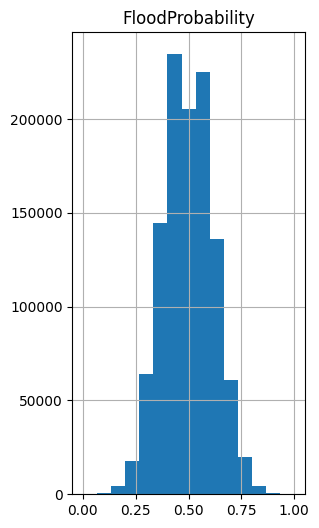

In [ ]:
target_scaler = MinMaxScaler()
target_scaler.fit(label_train_standardized)
label_train_transformed = target_scaler.transform(label_train_standardized)
label_train_transformed = pd.DataFrame(label_train_transformed, columns=[target_column])
label_train_transformed.hist(bins=15, figsize=(3, 6))

> this looks much better

### Splitting data into training and testing datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features_train_standardized, label_train_transformed, test_size=0.25
)

In [ ]:
# verifying the columns
X_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

#### **Taking a look at the heatmap of the feature space**

<Axes: >

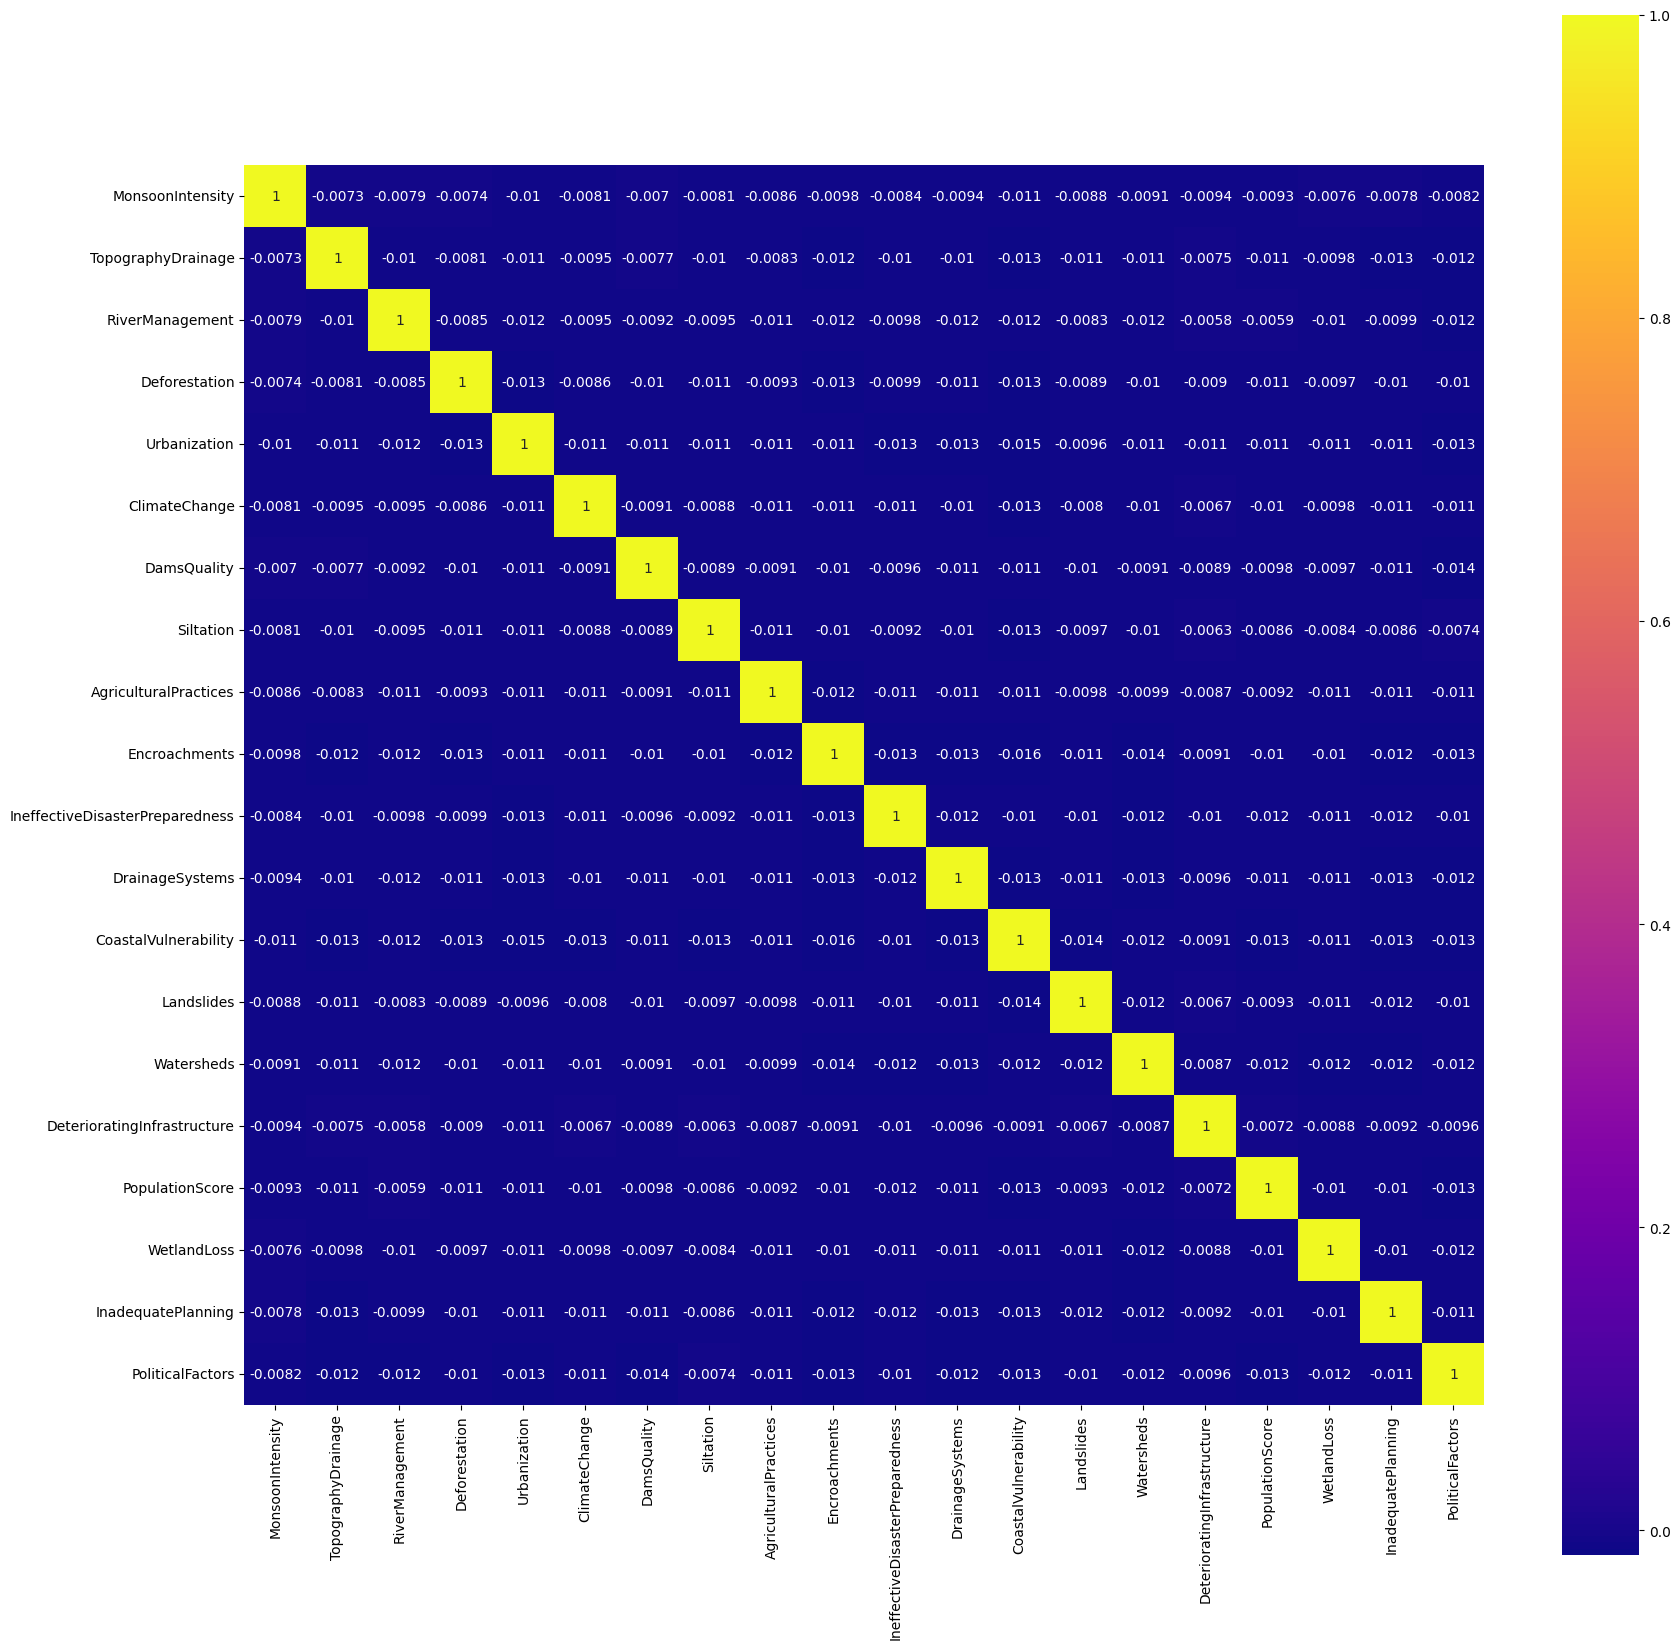

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_train.corr(), vmax=1, square=True, annot=True, cmap="plasma")

## **Feature Analyzer**

Analyzing features:


-----------------------------------
PCA Loadings 
-----------------------------------

                                      PC1       PC2       PC3       PC4  \
MonsoonIntensity                 0.046108  0.077559 -0.054020  0.160110   
TopographyDrainage               0.178202 -0.302993 -0.076813  0.252069   
RiverManagement                 -0.118696 -0.171618  0.552898 -0.091069   
Deforestation                    0.206481 -0.038882  0.232529  0.457043   
Urbanization                    -0.287495 -0.175203 -0.481902  0.036034   
ClimateChange                   -0.078535 -0.062229  0.094619  0.179248   
DamsQuality                      0.073342 -0.292773 -0.142994 -0.063927   
Siltation                       -0.165059  0.330086  0.014508 -0.095071   
AgriculturalPractices            0.177651 -0.184300 -0.112164  0.145529   
Encroachments                   -0.456863  0.015130 -0.267122 -0.185252   
IneffectiveDisasterPreparedness  0.235360  0.207806  0.042690 -0.092556   
DrainageSyst

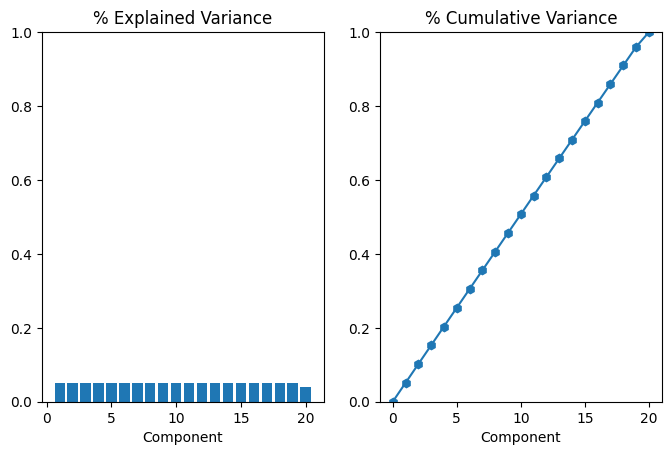

In [ ]:
class FeatureAnalyzer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.pca = PCA()
        self.pca.fit_transform(self.X)

    @property
    def X_pca(self):
        x_pca = self.pca.fit_transform(self.X)
        return pd.DataFrame(x_pca, columns=[f"PC{i+1}" for i in range(x_pca.shape[1])])

    @property
    def pca_loadings(self):
        return pd.DataFrame(self.pca.components_.T, columns=self.X_pca.columns, index=self.X.columns)

    def plot_variance(self, width=8, dpi=100):
        fig, axes = plt.subplots(1, 2)
        n = self.pca.n_components_
        print(f"\n{'-' * 35}\nPCA Loadings \n{'-' * 35}\n")
        print(self.pca_loadings)
        grid = np.arange(1, n+1)
        explained_variance = self.pca.explained_variance_ratio_
        axes[0].bar(grid, explained_variance)
        axes[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
        cumulative_variance = np.cumsum(explained_variance)
        axes[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], marker="h")
        axes[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
        fig.set(figwidth=width, dpi=dpi)
        return axes

    def make_mi_scores(self, discrete_features: bool = False):
        mi_regression = mutual_info_regression(self.X, self.y, discrete_features=discrete_features)
        return pd.Series(mi_regression, name="Mutual Info Scores", index=self.X.columns).sort_values(ascending=False)

    def check_outliers(self):
        sns.catplot(
            y="value",
            col="variable",
            data=self.X_pca.melt(),
            kind="boxen",
            sharey=False,
            col_wrap=2
        )


def show_feature_analysis_artifacts(X, y, show_mi_scores=True, show_outliers=True):
    feature_analyzer = FeatureAnalyzer(X, y)
    feature_analyzer.plot_variance()
    if show_mi_scores:
        mi_scores = feature_analyzer.make_mi_scores()
        print(f"\n{'-' * 35}\nMutual Information Scores \n{'-' * 35}\n")
        print(mi_scores)
    if show_outliers:
        feature_analyzer.check_outliers()
    return feature_analyzer


feature_analyzer_object = show_feature_analysis_artifacts(
    X_train, y_train, show_mi_scores=False, show_outliers=False
)

## **Visualization for PCA**

In [ ]:
class Charts:
    def __init__(self, data, width=18, height=9, font_family="Sans Serif"):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.data = data
        self.y_pos = [i * 0.9 for i in range(len(data))]
        self.ax.barh(
            self.y_pos,
            self.data.values(),
            height=0.55,
            align="edge",
            color="blue",
        )
        self.font_family = font_family

    @property
    def max_data_value(self):
        return max(self.data.values())

    @property
    def min_data_value(self):
        return min(self.data.values())

    @property
    def axis_period(self):
        return int(self.max_data_value) // 10 or 1

    def set_axes(self):
        from math import ceil
        data_size = len(self.data)
        num_ticks = ceil(self.max_data_value)
        self.ax.xaxis.set_ticks([i * self.axis_period for i in range(num_ticks)])
        self.ax.xaxis.set_ticklabels(
            [i * self.axis_period for i in range(0, num_ticks)],
            size=16,
            fontfamily=self.font_family,
            fontweight=100,
        )
        self.ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
        self.ax.set_axisbelow(True)
        self.ax.grid(axis="x", color="#8C92AC", lw=1.2)
        self.ax.spines["left"].set_visible(False)
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)
        self.ax.spines["bottom"].set_visible(False)
        self.ax.spines["left"].set_lw(1.5)
        self.ax.spines["left"].set_capstyle("butt")
        self.ax.yaxis.set_visible(False)
        return self

    def add_bar_text(self, label_object: dict):
        self.ax.text(
            x=label_object["x_pos"],
            y=label_object["y_pos"],
            s=label_object["text"],
            c=label_object["color"],
            fontfamily=self.font_family,
            fontsize=12,
            va="center",
            path_effects=label_object["path_effects"],
        )

    def add_labels(self, padding: float = 0.3):
        offset = 0.04
        for label, value, y_pos in zip(
            self.data.keys(), self.data.values(), self.y_pos
        ):
            metric_label = dict(
                x_pos=int(self.min_data_value) + (padding * 2.2),
                y_pos=(y_pos + 0.25),
                text=label,
                color="white",
                path_effects=[withStroke(linewidth=6, foreground="green")]
            )
            value_label = dict(
                x_pos=value,
                y_pos=(y_pos + 0.25),
                text=f"{round(value, 3)}0",
                color="green",
                path_effects=[withStroke(linewidth=6, foreground="white")]
            )
            if value < 0:
                metric_label["x_pos"] = self.min_data_value - (padding * 0.7) - offset
                metric_label["path_effects"] = [withStroke(linewidth=6, foreground="red")]
                metric_label["color"] = "white"
                value_label["color"] = "red"
                value_label["x_pos"] -= offset
            self.add_bar_text(metric_label)
            self.add_bar_text(value_label)

        return self

    def add_title(self, title, pos=0.5):
        self.fig.text(
            pos, 0.925, title, fontsize=16, fontweight="bold", fontfamily=self.font_family
        )
        return self

    def plot(self, title=None):
        self.set_axes().add_labels()
        if title:
            self.add_title(title)
        plt.show()


Plotting the first principal component

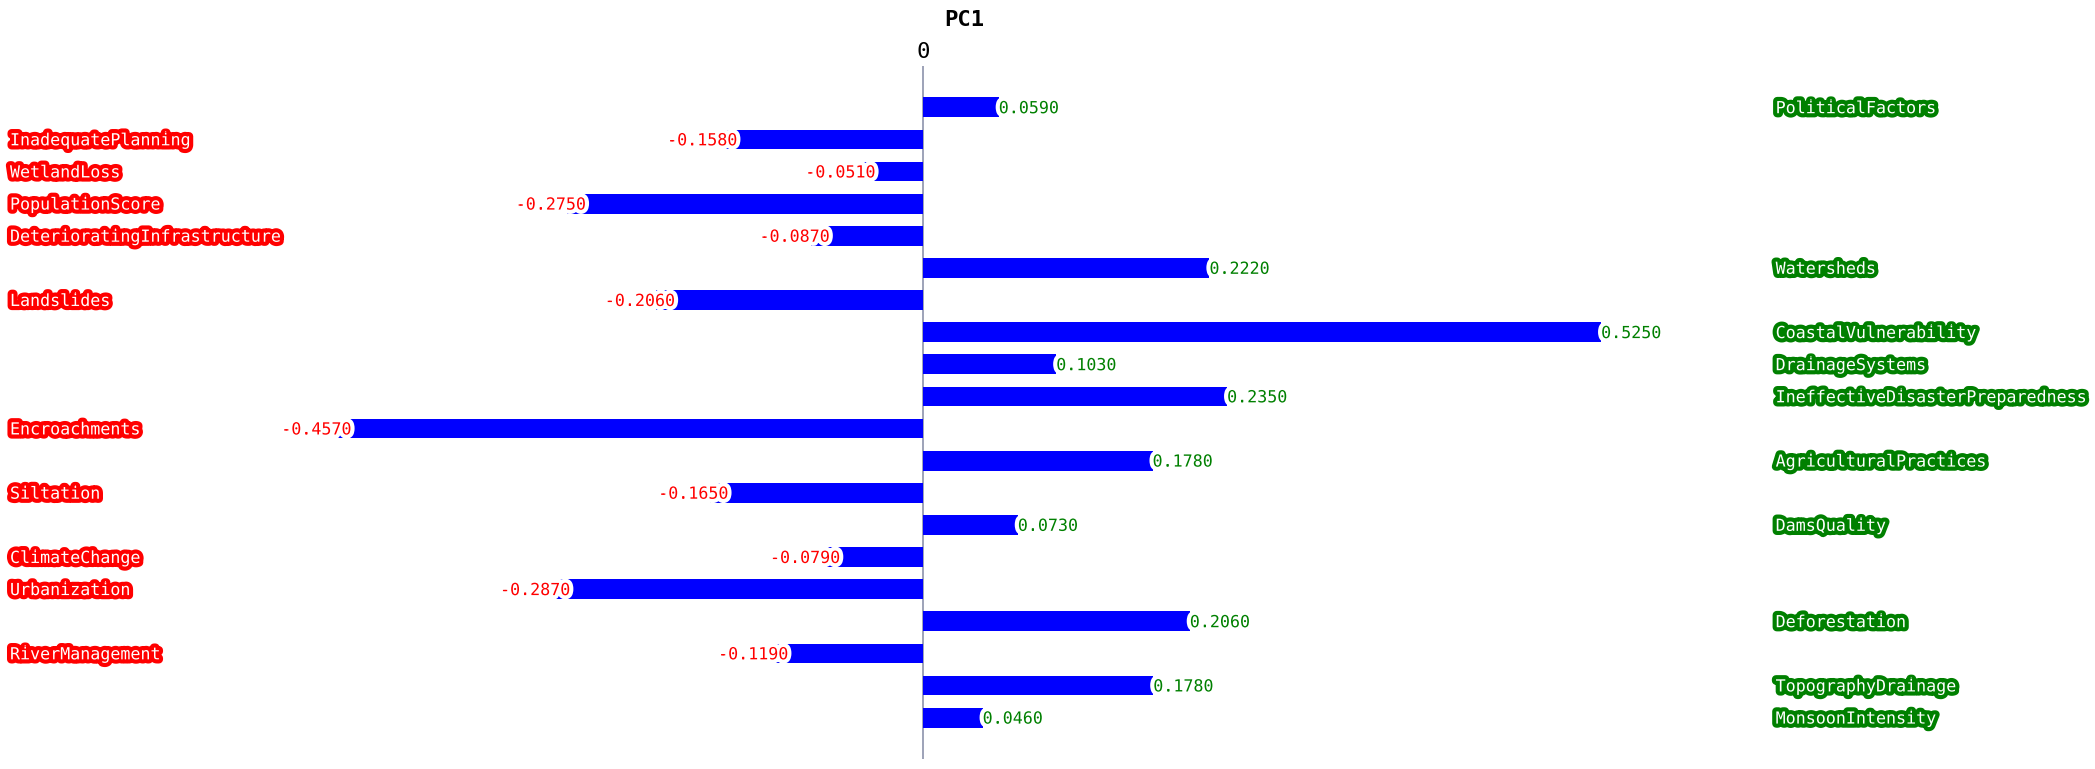

In [ ]:
def plot_principal_component(feature_analyzer_object, level=1):
    if level < 1:
        raise ValueError("PC level can't be less than 1")
    _loadings = feature_analyzer_object.pca_loadings
    _column = _loadings.columns[level - 1]
    pc_dataframe = _loadings.loc[:, _column].reset_index().to_dict(orient="records")
    feature_to_pc1 = {_entry["index"]: float(_entry[_column]) for _entry in pc_dataframe}
    chart = Charts(data=feature_to_pc1, font_family="monospace")
    chart.plot(title=_column)

plot_principal_component(feature_analyzer_object, level=1)

#### **Enhancing the features based on the PCA analysis**

In [ ]:
X_train_pca = feature_analyzer_object.pca.fit_transform(X_train)
X_test_pca = feature_analyzer_object.pca.transform(X_test)

## **Modeling**

In [ ]:
from collections import defaultdict

models = defaultdict(list)

### **Trying the RandomForestRegressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor


class RandomForestRegression:
    def __init__(self, train_data, test_data, feature_list, target, num_trees=10, criterion="absolute_error"):
        self.regressor = RandomForestRegressor(
            n_estimators=num_trees,
            criterion=criterion,
            n_jobs=-1
        )
        self.train_data = train_data
        self.test_data = test_data
        self.feature_list = feature_list
        self.target = target

    def fit(self):
        train_features, train_labels = self.train_data
        self.regressor.fit(train_features, train_labels)
        return self

    def predict(self):
        test_features, test_labels = self.test_data
        assert isinstance(test_features, np.ndarray)
        assert isinstance(test_labels, pd.DataFrame)
        dataframe = pd.DataFrame(test_features, columns=self.feature_list)
        dataframe[self.target] = test_labels
        dataframe["predictions"] = self.regressor.predict(test_features)
        self.prediction_data = dataframe
        return self

    def set_metrics(self):
        y_pred, y_true = self.prediction_data["predictions"], self.prediction_data[self.target]
        self.r2_score = r2_score(y_true, y_pred)

In [ ]:
rf_regressor_model = RandomForestRegression(
    train_data=(X_train_pca, y_train),
    test_data=(X_test_pca, y_test),
    feature_list=X_train.columns,
    target=target_column,
    num_trees=5
)
# rf_regressor_model.fit().train().set_metrics()

> this took forever to converge to a result; * *sigh* * moving on...

### **XGBoost Regressor**

#### Training the XGBRegressor model:

In [ ]:
xgbregressor_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    early_stopping_rounds=500,
    n_jobs=5,
    reg_lambda=1e-4,
    tree_method="hist",
    eval_metric=r2_score
)
xgbregressor_model.fit(X_train_pca, y_train, eval_set=[(X_test_pca, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False,
             eval_metric=<function r2_score at 0x7f7a96b18160>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=5, num_parallel_tree=None, random_state=None, ...)

#### Calculating the predictions:

In [ ]:
predictions_valid = xgbregressor_model.predict(X_test_pca)

#### Checking the error metric

In [ ]:
from sklearn.metrics import mean_squared_error

print(f"Validation set prediction error: {mean_squared_error(y_test, predictions_valid):.4f}")

Validation set prediction error: 0.0113


#### Making final predictions

In [ ]:
test_features = test_data.set_index("id")
final_predictions = xgbregressor_model.predict(test_features)

### **Conveying the $R^2$ score**

In [ ]:
r2_score_max = max(xgbregressor_model.evals_result_["validation_0"]["r2_score"])
print(f"R2 Score: {r2_score_max}")

R2 Score: 0.860378


## **Saving the output**

Storing the result in the submission file

In [ ]:
output_df = pd.DataFrame(final_predictions, columns=[target_column], index=test_data.id).reset_index().rename(columns={"index": "id"})
output_df.to_csv("submission.csv", index=False)